## COLAB PREP
(Commented out for safety)

**Note**:
Changing colab runtime to gpu will benefit performance.

In [ ]:
# !pip install cython
# !pip install pymc==2.3.8 # backend probabilistic programming framework (DO NOT USE CONDA HERE)
# !pip install git+https://github.com/AlexanderFengler/ssms@main  # package for data simulation
# !pip install git+https://github.com/hddm-devs/kabuki # backbone package for hddm to connect to pymc
# !pip install git+https://github.com/hddm-devs/hddm

# # Optional
# !pip install torch torchvision torchaudio # The LAN extension makes use of these

## Module imports

In [5]:
import pickle
from matplotlib import pyplot as plt

import hddm
import ssms

## Data Simulation

In [6]:
from hddm.simulators import simulator

help(simulator)

Help on function simulator in module hddm.simulators.basic_simulator:

simulator(**kwargs)
    Basic data simulator for the models included in HDDM.
    
    :Arguments:
        theta : list or numpy.array or panda.DataFrame
            Parameters of the simulator. If 2d array, each row is treated as a 'trial'
            and the function runs n_sample * n_trials simulations.
        model: str <default='angle'>
            Determines the model that will be simulated.
        n_samples: int <default=1000>
            Number of simulation runs (for each trial if supplied n_trials > 1)
        delta_t: float
            Size fo timesteps in simulator (conceptually measured in seconds)
        max_t: float
            Maximum reaction the simulator can reach
        no_noise: bool <default=False>
            Turn noise of (useful for plotting purposes mostly)
    
    :Return: tuple
        can be (rts, responses, metadata)
        or     (rt-response histogram, metadata)
        or     (

Simulate from `angle` model! (Bound collaps linearly according to an `angle-parameter` `theta`).

First, check `model_config` dictionary for general information about the model.

In [7]:
hddm.model_config.model_config["angle"]

{'doc': 'Model formulation is described in the documentation under LAN Extension.\nMeant for use with the extension.',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'params_trans': [0, 0, 1, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'params_default': [0.0, 1.0, 0.5, 0.001, 0.1],
 'hddm_include': ['v', 'a', 't', 'z', 'theta'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'theta': 0.1,
  'theta_std': 0.2}}

Below, please find some specifics about the `key`s in the `model_config` dictionary.

`params` --> string names of all model parameters (spcifies order in which associated values are defined)

`param_bounds` --> list of lists, first provides *lower bounds*, second provides *upper bounds* on parameters

`boundary` --> function that provides boundary values for vector inputs of `t` given the named parameter (it's applied symmetrically around 0 as upper and lower bounds)

**Note**:

Our Neural Nets are trained on the parameter bounds listed under `param_bounds`, so they roughly specify what we consider a reasonable parameter space.

In [8]:
out = simulator(model="angle", theta=[1.0, 1.5, 0.5, 0.5, 0.3], n_samples=1000)

`out` is a three-tuple with entries:
1. `rts` (reaction times) (array)
2. `choices` (array)
3. `metadata` (dict)

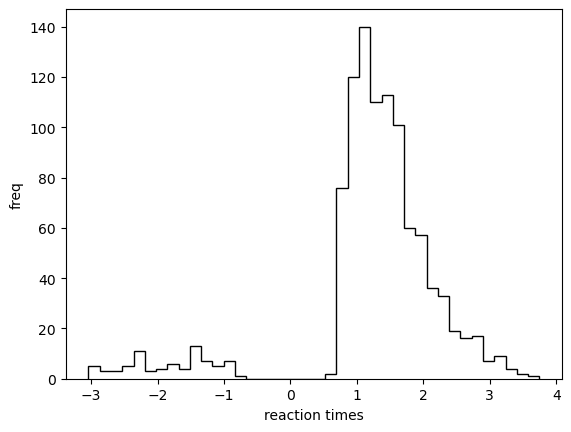

In [9]:
import numpy as np

plt.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black"
)
plt.xlabel("reaction times")
plt.ylabel("freq")
plt.show()

## Fit with HDDM

In [12]:
import numpy as np
import pandas as pd

# Get data into format accepted by hddm package (below)
data = pd.DataFrame(
    np.stack([np.squeeze(out[0]), np.squeeze(out[1])]).T, columns=["rt", "response"]
)
data["subject"] = 0

In [11]:
data

,rt,response,subject
0,1.159995,1.0,0
1,1.442991,-1.0,0
2,1.197995,1.0,0
3,1.312993,1.0,0
4,1.929011,1.0,0
...,...,...,...
995,1.022997,1.0,0
996,0.817999,1.0,0
997,1.779004,1.0,0
998,1.148995,1.0,0


In [32]:
# Instantiate model
# Prior is uniform over hypercube specified by `param_bounds`
# in the model_config above
hddm_model = hddm.HDDMnn(
    data,
    model="angle",
    include=[
        "v",
        "a",
        "z",
        "t",
        "theta",
    ],  # can use 'hddm_include' key in model_config here
)

Using default priors: Uninformative
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [33]:
# Sample (MCMC via slice sampler)
hddm_model.sample(1000, burn=500)

 [-----------------100%-----------------] 1000 of 1000 complete in 99.3 sec

In [35]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,1.178377,0.062941,1.057531,1.137134,1.180993,1.21869,1.293596,0.005173
a,1.475904,0.074743,1.333122,1.417689,1.47974,1.536166,1.599496,0.007104
z,0.467073,0.019607,0.427542,0.454486,0.466104,0.480852,0.502805,0.001727
t,0.49229,0.029895,0.436686,0.468518,0.4914,0.516715,0.549136,0.002798
theta,0.288985,0.043242,0.201595,0.259133,0.291414,0.320974,0.36275,0.003864


**Note**:

Depending on the model and ground truth parameters, mixing can be rough (the number of samples chose above is just for testing, result quality benefits from ramping up the number of MCMC samples).

Plotting v
Plotting a
Plotting z
Plotting t
Plotting theta


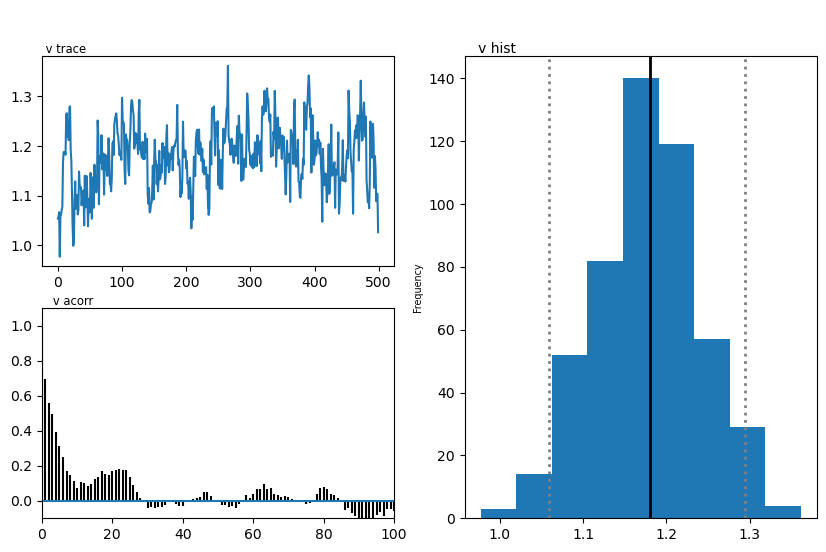

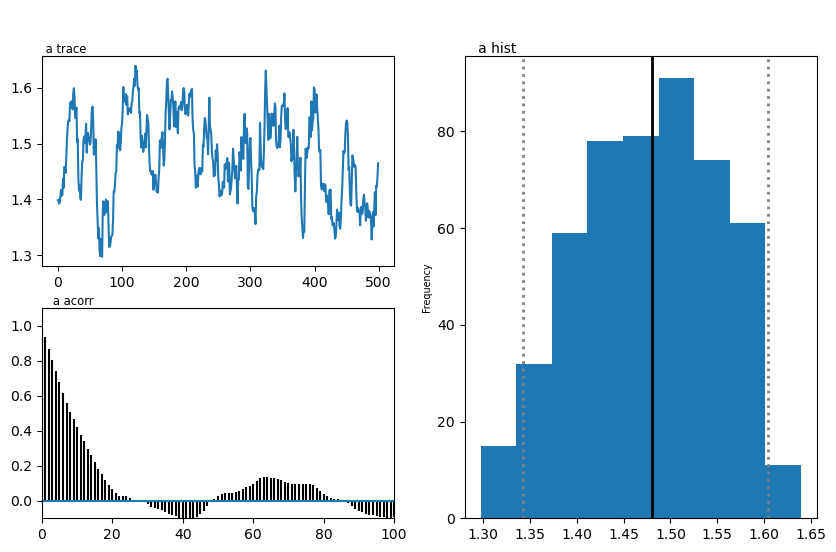

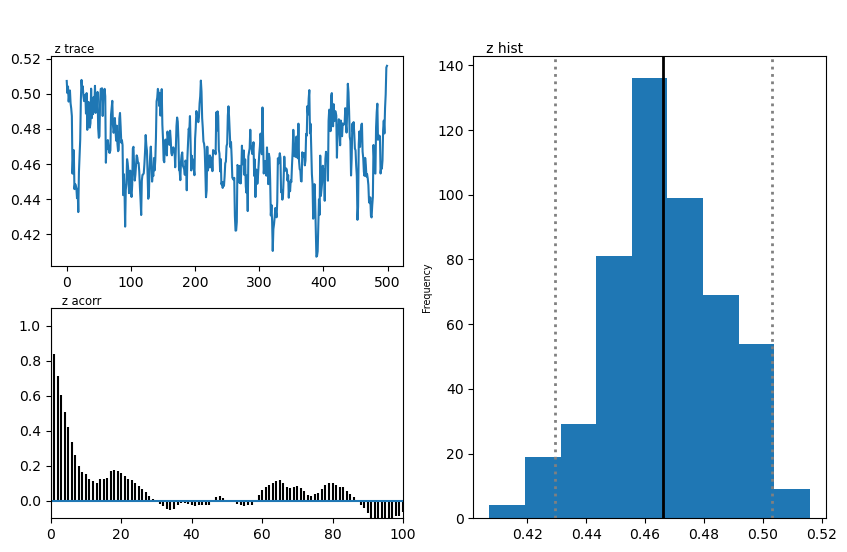

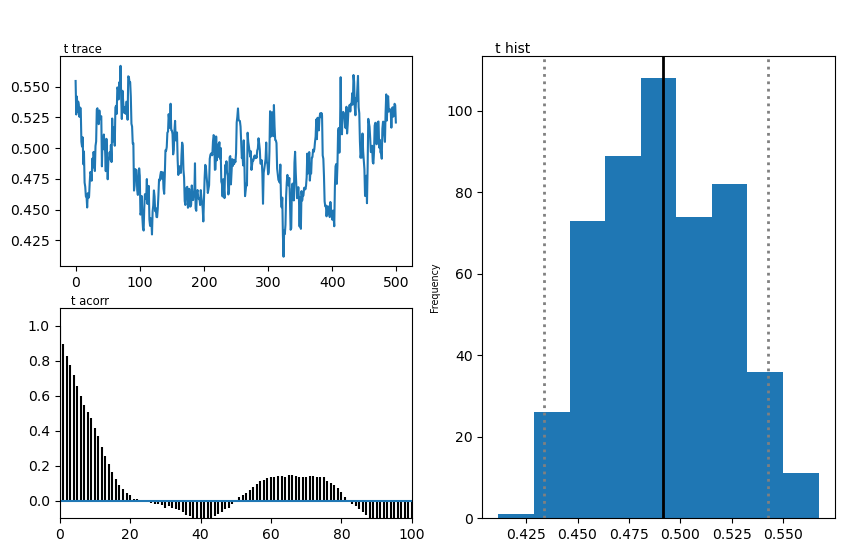

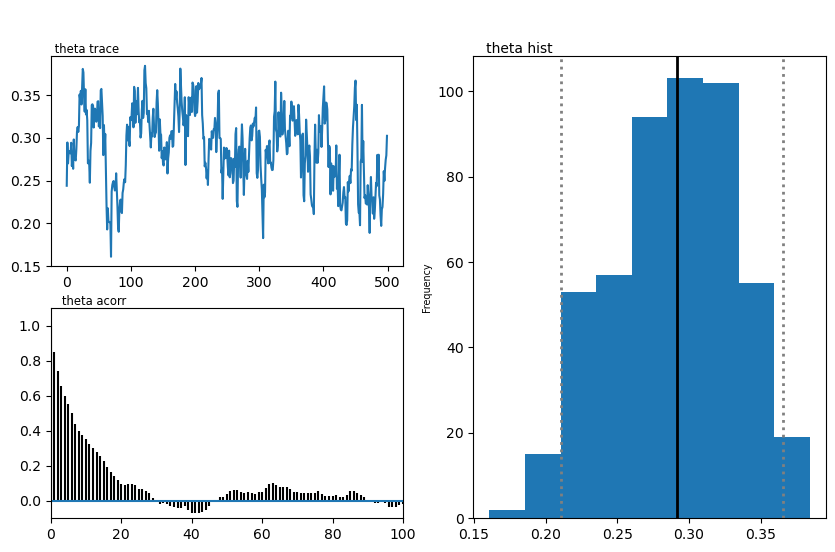

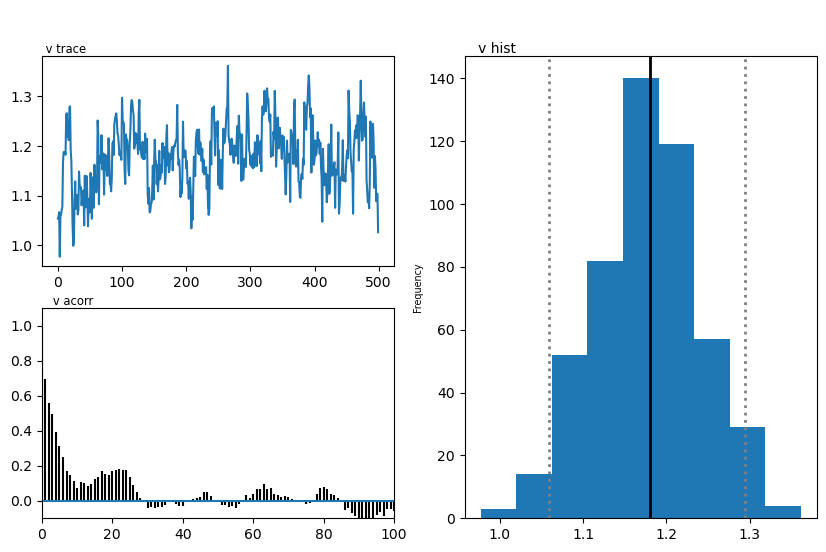

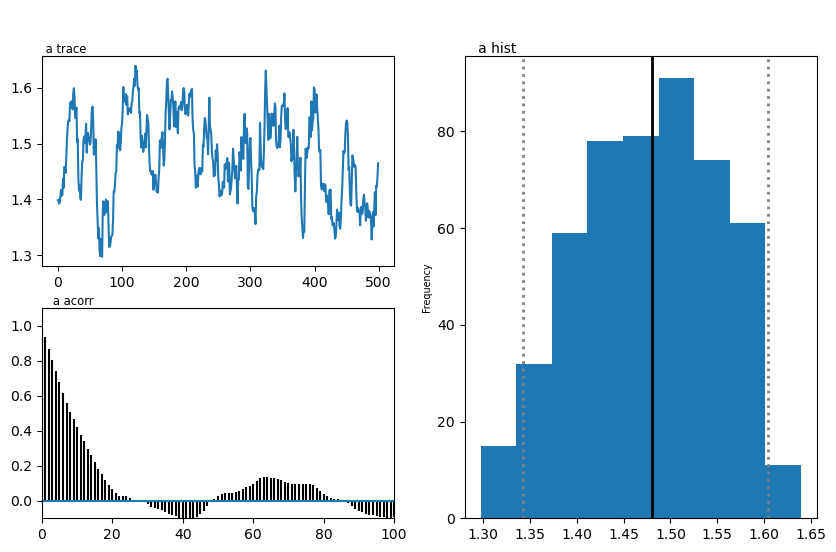

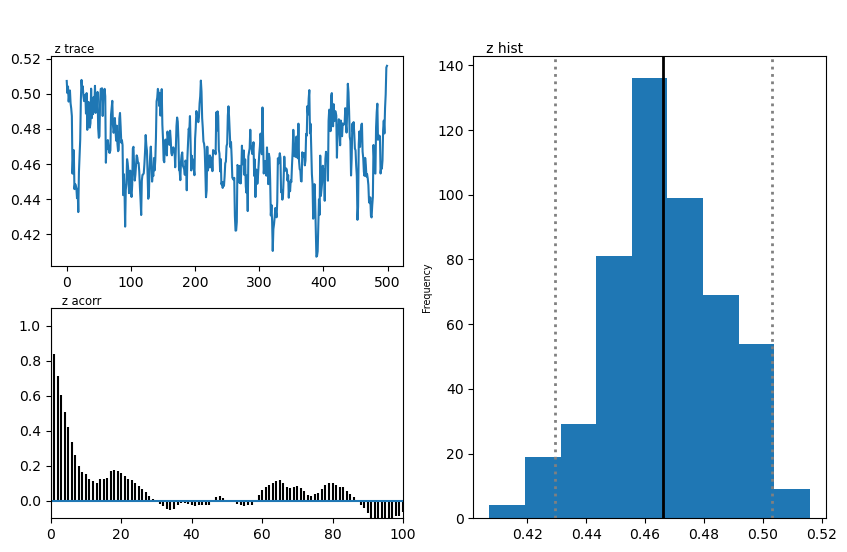

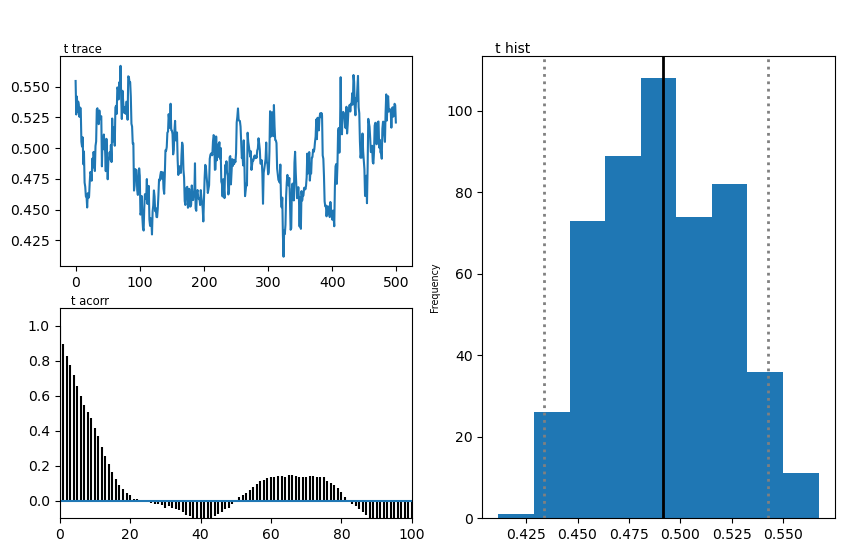

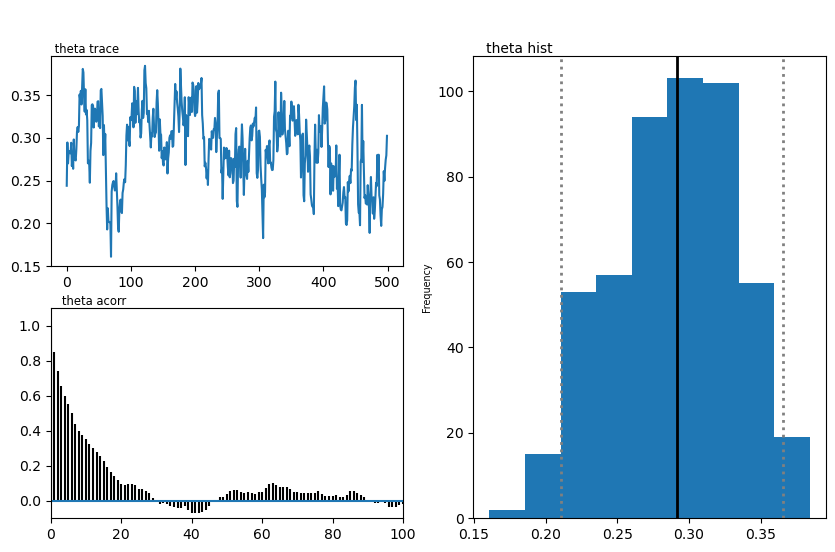

In [40]:
hddm_model.plot_posteriors()
plt.show()

## Access trained likelihood (networks)

You can get the predictions from the `likelihood aproximators` directly via the `network_inspectors` module.

Just in case it's useful.

The networks expects as inputs a `numpy.array` of `n_model_parameters + 2` dimensions. 
The first `n` parameters are (column wise) provided in the order found in under the `params` key in the `model_config` dictionary above. Finally a `rt` colum and a `choice` column.

In [ ]:
# Get the model
lan_angle = hddm.network_inspectors.get_torch_mlp(model="angle")

In [46]:
# Make some random parameter set
parameter_df = hddm.simulators.make_parameter_vectors_nn(
    model="angle", param_dict=None, n_parameter_vectors=1
)

parameter_matrix = np.tile(np.squeeze(parameter_df.values), (200, 1))

# Initialize network input
network_input = np.zeros(
    (parameter_matrix.shape[0], parameter_matrix.shape[1] + 2)
)  # Note the + 2 on the right --> we append the parameter vectors with reaction times (+1 columns) and choices (+1 columns)

# Add reaction times
network_input[:, -2] = np.linspace(0, 3, parameter_matrix.shape[0])

# Add choices
network_input[:, -1] = np.repeat(np.random.choice([-1, 1]), parameter_matrix.shape[0])

# Note: The networks expects float32 inputs
network_input = network_input.astype(np.float32)

# Show example output
print("Some network outputs")
print(lan_angle(network_input)[:10])  # printing the first 10 outputs
print("Shape")
print(lan_angle(network_input).shape)  # original shape of output

Some network outputs
[[ 4.2394323 ]
 [ 1.557178  ]
 [ 0.6721666 ]
 [ 0.03607679]
 [-0.5329498 ]
 [-0.98186684]
 [-1.3941536 ]
 [-1.8228109 ]
 [-2.2679203 ]
 [-2.7137465 ]]
Shape
(200, 1)


In [47]:
network_input.shape

(200, 7)

## P.S.:

There are many other models included in `hddm`.
Apart from the `angle` model, there is also the `weibull` model which uses a *scaled weibull cdf* as a bound and may be of more immediate interest. 

In general parameter recovery can be tricky, especially for the simple i.i.d. datasets. 

In [13]:
hddm.model_config.model_config.keys()

dict_keys(['ddm_hddm_base', 'full_ddm_hddm_base', 'ddm', 'angle', 'weibull', 'levy', 'full_ddm', 'ornstein', 'ddm_sdv', 'gamma_drift', 'gamma_drift_angle', 'ds_conflict_drift', 'ds_conflict_drift_angle', 'ddm_par2', 'ddm_par2_no_bias', 'ddm_par2_angle_no_bias', 'ddm_par2_weibull_no_bias', 'ddm_seq2', 'ddm_seq2_no_bias', 'ddm_seq2_angle_no_bias', 'ddm_seq2_weibull_no_bias', 'ddm_mic2_adj', 'ddm_mic2_adj_no_bias', 'ddm_mic2_adj_angle_no_bias', 'ddm_mic2_adj_weibull_no_bias', 'tradeoff_no_bias', 'tradeoff_angle_no_bias', 'tradeoff_weibull_no_bias', 'tradeoff_conflict_gamma_no_bias', 'race_no_bias_3', 'race_no_bias_angle_3', 'race_no_bias_4', 'race_no_bias_angle_4', 'lca_no_bias_3', 'lca_no_bias_angle_3', 'lca_no_bias_4', 'lca_no_bias_angle_4', 'full_ddm2'])

In [14]:
hddm.model_config.model_config["weibull"]

{'doc': 'Model formulation is described in the documentation under LAN Extension.\nMeant for use with the extension.',
 'params': ['v', 'a', 'z', 't', 'alpha', 'beta'],
 'params_trans': [0, 0, 1, 0, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 2.0, 2.0],
 'param_bounds': [[-2.5, 0.3, 0.2, 0.001, 0.31, 0.31],
  [2.5, 2.5, 0.8, 2.0, 4.99, 6.99]],
 'boundary': <function ssms.basic_simulators.boundary_functions.weibull_cdf(t=1, alpha=1, beta=1)>,
 'params_default': [0.0, 1.0, 0.5, 0.001, 3.0, 3.0],
 'hddm_include': ['v', 'a', 't', 'z', 'alpha', 'beta'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'alpha': 1.0,
  'alpha_std': 0.5,
  'beta': 1.0,
  'beta_std': 0.5}}

## END